In [ ]:
!pip install --upgrade pip --quiet

!pip install patsy --quiet
!pip install holoviews --quiet
!pip install scikit-learn --quiet
!pip install tqdm --quiet
!pip install plotly --quiet
!pip install plotly-express --quiet
!pip install chart_studio --quiet

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import patsy
from tqdm import tqdm
import holoviews as hv
from sklearn.linear_model import PassiveAggressiveRegressor, LinearRegression
from sklearn.base import BaseEstimator
from dataclasses import dataclass

import chart_studio.plotly as py
import plotly_express as px


#hv.extension('matplotlib')
#%%opts Curve  [height=200 width=900 xaxis=None tools=['hover']]

# Spline Passive Aggressive Regression

# Parameters

In [ ]:
NOISE_FEATURE = 20

In [ ]:
NOISE_TARGET = 70

In [ ]:
FORECAST_LEADTIME = 5

In [ ]:
SPLINE_DEGREE_OF_FREEDOM = 11

In [ ]:

from datetime import datetime as _deepnote_datetime
START_TRANSITION = _deepnote_datetime.strptime('2019-08-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%fZ")


In [ ]:

from datetime import datetime as _deepnote_datetime
END_TRANSITION = _deepnote_datetime.strptime('2019-12-31T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%fZ")


In [ ]:
# Params preprocess anc check
NOISE_FEATURE /= 100
NOISE_TARGET /= 100

TRAIN_SPLIT_DATE = START_TRANSITION

if START_TRANSITION > END_TRANSITION:
    raise ValueError('START_TRANSITION must be before END_TRANSITION')


print('Current parameters:')
print('NOISE_FEATURE:', NOISE_FEATURE)
print('NOISE_TARGET:', NOISE_TARGET)
print('FORECAST_LEADTIME:', FORECAST_LEADTIME)
print('SPLINE_DEGREE_OF_FREEDOM:', SPLINE_DEGREE_OF_FREEDOM)
print('START_TRANSITION:', START_TRANSITION)
print('END_TRANSITION:', END_TRANSITION)

Current parameters:
NOISE_FEATURE: 0.1
NOISE_TARGET: 0.1
FORECAST_LEADTIME: 5
SPLINE_DEGREE_OF_FREEDOM: 10
START_TRANSITION: 2019-08-01 00:00:00
END_TRANSITION: 2019-12-31 00:00:00


# Dataset

In [ ]:
# Build dataset
index  = pd.DatetimeIndex(pd.date_range(start=datetime(2015, 1, 1), end=datetime(2023, 12, 31)))
data = pd.DataFrame(index = index)
data['dayofyear'] = data.index.dayofyear
data['feature'] = np.sin(2.* np.pi * data['dayofyear'] / 365) + np.random.randn(len(data)) * NOISE_FEATURE
data['target'] = np.abs((data['feature']  - 0.2 )) ** 3 + np.random.randn(len(data)) * NOISE_TARGET

In [ ]:
# Build shock and apply to target by multiplication
data['shock_coefficient'] = np.nan
data.loc[:START_TRANSITION, 'shock_coefficient'] = 1
data.loc[END_TRANSITION + timedelta(days=1):, 'shock_coefficient'] = .5
data['shock_coefficient'] = data['shock_coefficient'].interpolate(method='linear') 

data['target_shock'] = data['shock_coefficient'] * data['target']

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


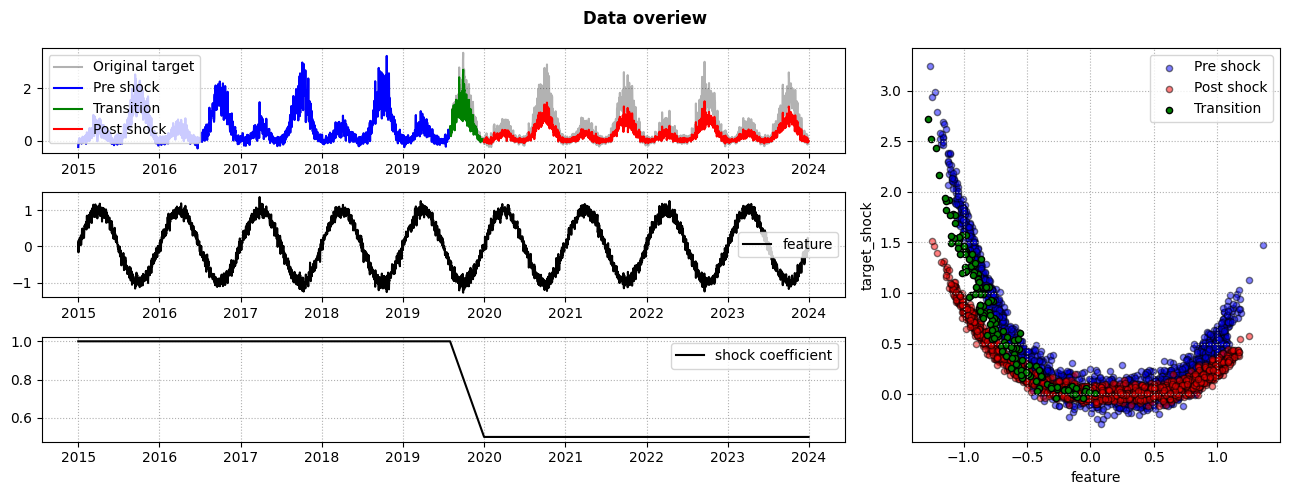

In [ ]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Data overiew', fontweight='bold')

ax_ts_1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=1, colspan=2, fig=fig)
ax_ts_2 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), rowspan=1, colspan=2)
ax_ts_3 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), rowspan=1, colspan=2)
ax_scatter = plt.subplot2grid(shape=(3, 3), loc=(0, 2), rowspan=3, colspan=1)

# Timeseries
ax_ts_1.plot(data.index, data['target'], color='black', label='Original target', alpha=0.3)
ax_ts_1.plot(data.loc[:START_TRANSITION, :].index, data.loc[:START_TRANSITION, 'target_shock'], color='blue', label='Pre shock')
ax_ts_1.plot(data.loc[START_TRANSITION:END_TRANSITION, :].index, data.loc[START_TRANSITION:END_TRANSITION, 'target_shock'], color='green', label='Transition')
ax_ts_1.plot(data.loc[END_TRANSITION:, :].index, data.loc[END_TRANSITION:, 'target_shock'], color='red', label='Post shock')

ax_ts_2.plot(data.index, data['feature'], color='black', label='feature')
ax_ts_3.plot(data.index, data['shock_coefficient'], color='black', label='shock coefficient')


# Scatter
data.loc[:START_TRANSITION, :].plot.scatter(x = 'feature', y = 'target_shock', alpha=.5, color='blue', label='Pre shock', ax=ax_scatter, edgecolors='black')
data.loc[END_TRANSITION:, :].plot.scatter(x = 'feature', y = 'target_shock', alpha=.5, color='red', label='Post shock', ax=ax_scatter, edgecolors='black')
data.loc[START_TRANSITION:END_TRANSITION, :].plot.scatter(x = 'feature', y = 'target_shock', alpha=1, color='green', label='Transition', ax=ax_scatter, edgecolors='black')


ax_ts_1.grid(linestyle=':'), ax_ts_2.grid(linestyle=':'), ax_ts_3.grid(linestyle=':'), ax_scatter.grid(linestyle=':')
ax_ts_1.legend(), ax_ts_2.legend(), ax_ts_3.legend()



plt.tight_layout()

# Feature engineering

In [ ]:
# Build splines
y, X = patsy.dmatrices(f'target_shock ~ bs(feature, df={SPLINE_DEGREE_OF_FREEDOM}, degree=3, include_intercept=False)', data=data)

X = pd.DataFrame(X, index = data.index)
y = pd.DataFrame(y, index = data.index)[0]
y.name='target'

In [ ]:
# Split Train test
X_train = X.loc[:TRAIN_SPLIT_DATE, :]
y_train = y.loc[:TRAIN_SPLIT_DATE]

X_test = X.loc[TRAIN_SPLIT_DATE:, :]
y_test = y.loc[TRAIN_SPLIT_DATE:]

# Fit/predict

In [ ]:
# Simple (static) linear model
lin_mdl = LinearRegression(fit_intercept=False)
lin_mdl.fit(X_train, y_train)
y_lin_pred = pd.Series(lin_mdl.predict(X_test), index=X_test.index, name='lr_oneshot')

In [ ]:
# Loop on the test set. Update weights via partial_fit
pa_online_mdl = {}
pa_online_coeff = {}
y_pa_online_pred = {}

for C in [0.01, 0.1, 1, 10]:
    print(f'Running model with C={C}')
    pa_online_mdl[C] = PassiveAggressiveRegressor(fit_intercept=False, C=C)
    pa_online_mdl[C].fit(X_train, y_train)

    y_pa_online_pred[C] = pd.Series(np.nan, index=X_test.index, name='pa_online')
    pa_online_coeff[C] = pd.DataFrame(np.nan, index=X_test.index, columns = X.columns)

    # Update model and forecast N days ahead
    for t in tqdm(X_test.index[:-FORECAST_LEADTIME]):

        target_t = t + timedelta(days=FORECAST_LEADTIME)

        # Update model
        pa_online_mdl[C].partial_fit(X.loc[[t], :], y[[t]])
        y_pa_online_pred[C].loc[target_t] = pa_online_mdl[C].predict(X.loc[[target_t], :])
        pa_online_coeff[C].loc[t, :] = pa_online_mdl[C].coef_


Running model with C=0.01
100%|██████████| 1609/1609 [00:05<00:00, 272.86it/s]
Running model with C=0.1
100%|██████████| 1609/1609 [00:05<00:00, 270.94it/s]
Running model with C=1
100%|██████████| 1609/1609 [00:05<00:00, 270.94it/s]
Running model with C=10
100%|██████████| 1609/1609 [00:05<00:00, 273.46it/s]


# Plot results

In [ ]:
# Prepare plot_df
highlight_plot_df = pd.concat(y_pa_online_pred, axis=1).dropna()
highlight_plot_df = pd.concat([y_test, highlight_plot_df, y_lin_pred], axis=1)

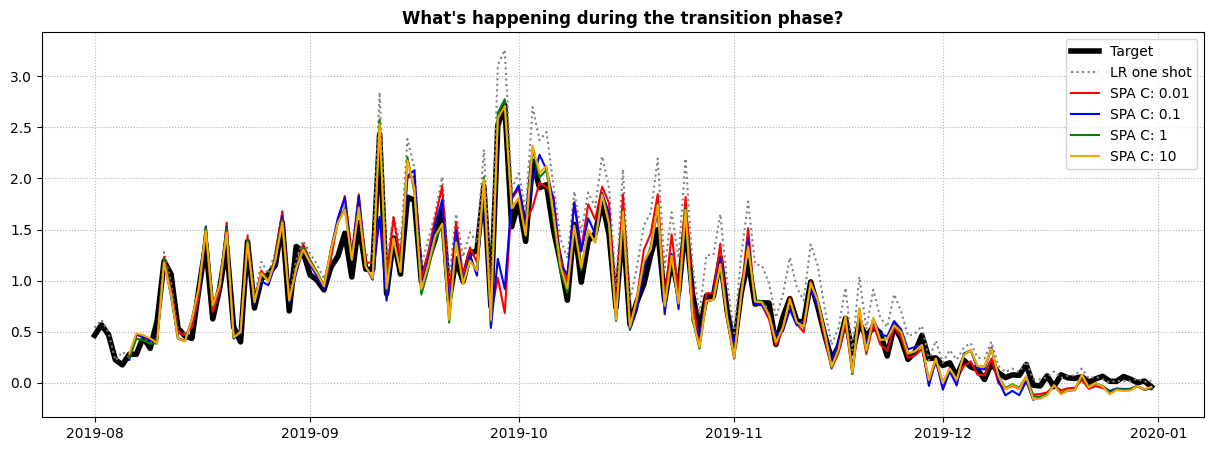

In [ ]:
# Plot highlights
title = "What's happening during the transition phase?"
start_plot = START_TRANSITION
end_plot = END_TRANSITION
idx = highlight_plot_df.loc[start_plot:end_plot, :].index

fig = plt.figure(figsize=(15, 5))
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 'target'], color='black', label='Target', linewidth=4)
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 'lr_oneshot'], color='gray', label='LR one shot', linestyle='dotted')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 0.01], color='red', label='SPA C: 0.01')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 0.1], color='blue', label='SPA C: 0.1')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 1], color='green', label='SPA C: 1')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 10], color='orange', label='SPA C: 10')
plt.title(title, fontweight='bold')
plt.legend()
plt.grid(linestyle=':')


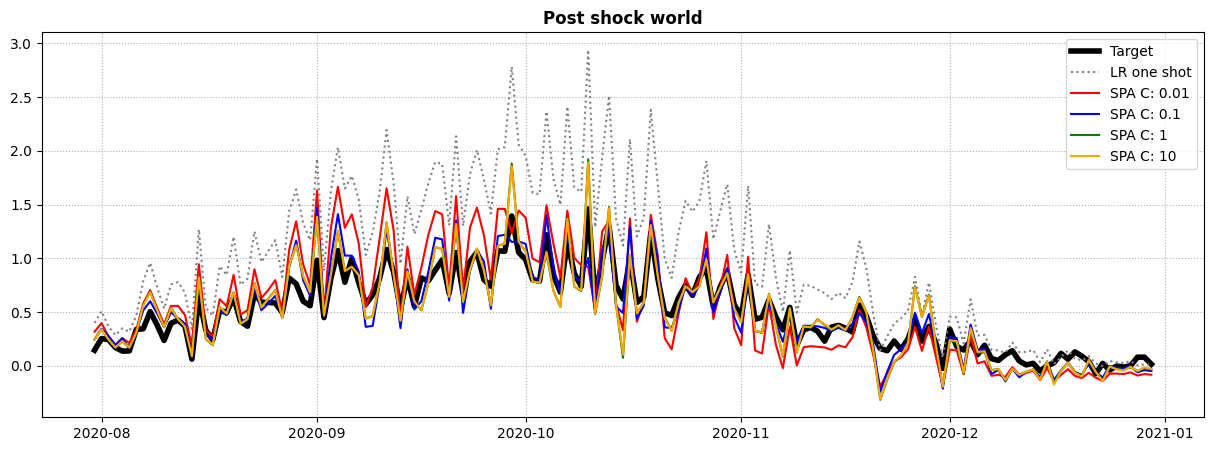

In [ ]:
# Plot highlights
title = "Post shock world"
start_plot = START_TRANSITION + timedelta(days=365)
end_plot = END_TRANSITION + timedelta(days=365)
idx = highlight_plot_df.loc[start_plot:end_plot, :].index

fig = plt.figure(figsize=(15, 5))
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 'target'], color='black', label='Target', linewidth=4)
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 'lr_oneshot'], color='gray', label='LR one shot', linestyle='dotted')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 0.01], color='red', label='SPA C: 0.01')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 0.1], color='blue', label='SPA C: 0.1')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 1], color='green', label='SPA C: 1')
plt.plot(idx, highlight_plot_df.loc[start_plot:end_plot, 10], color='orange', label='SPA C: 10')
plt.title(title, fontweight='bold')
plt.legend()
plt.grid(linestyle=':')

In [ ]:
# Plot timeseries
plot_df = pd.concat(y_pa_online_pred, axis=1).dropna()
plot_df = pd.concat([y_test, plot_df, y_lin_pred], axis=1)
plot_df = plot_df[['target', 'lr_oneshot', 0.01, 1, 10, 0.1]]
plot_df.columns = [str(x) for x in plot_df.columns]

px.line(data_frame=plot_df, y=['target', 'lr_oneshot', '0.01', '0.1','1.0','10.0'], title='Test set')


In [ ]:
# Build dataset of spline evolution
feature_domain = pd.DataFrame({'feature': np.linspace(data['feature'].min(), data['feature'].max(), 1000)})
spline_df = pd.DataFrame(patsy.dmatrix('bs(feature, df=10, degree=3, include_intercept=True)', data=feature_domain))

spline_history = {}

for C in [0.01, 0.1, 1, 10]:
    print(f'Running model with C={C}')
    spline_history_tmp = pd.DataFrame(columns=['valuedate', 'feature', 'spline'])
    for vd in tqdm(pa_online_coeff[C].dropna().index):
        coef = pa_online_coeff[C].loc[vd, :]
        current_spline = (spline_df * coef).sum(axis=1).to_frame('spline')

        current_spline['feature'] = feature_domain
        current_spline['valuedate'] =vd
        spline_history_tmp = pd.concat([spline_history_tmp, current_spline], axis=0)

    spline_history[C] = spline_history_tmp

Running model with C=0.01
100%|██████████| 1609/1609 [00:11<00:00, 139.83it/s]
Running model with C=0.1
100%|██████████| 1609/1609 [00:09<00:00, 161.39it/s]
Running model with C=1
100%|██████████| 1609/1609 [00:09<00:00, 161.50it/s]
Running model with C=10
100%|██████████| 1609/1609 [00:09<00:00, 173.52it/s]


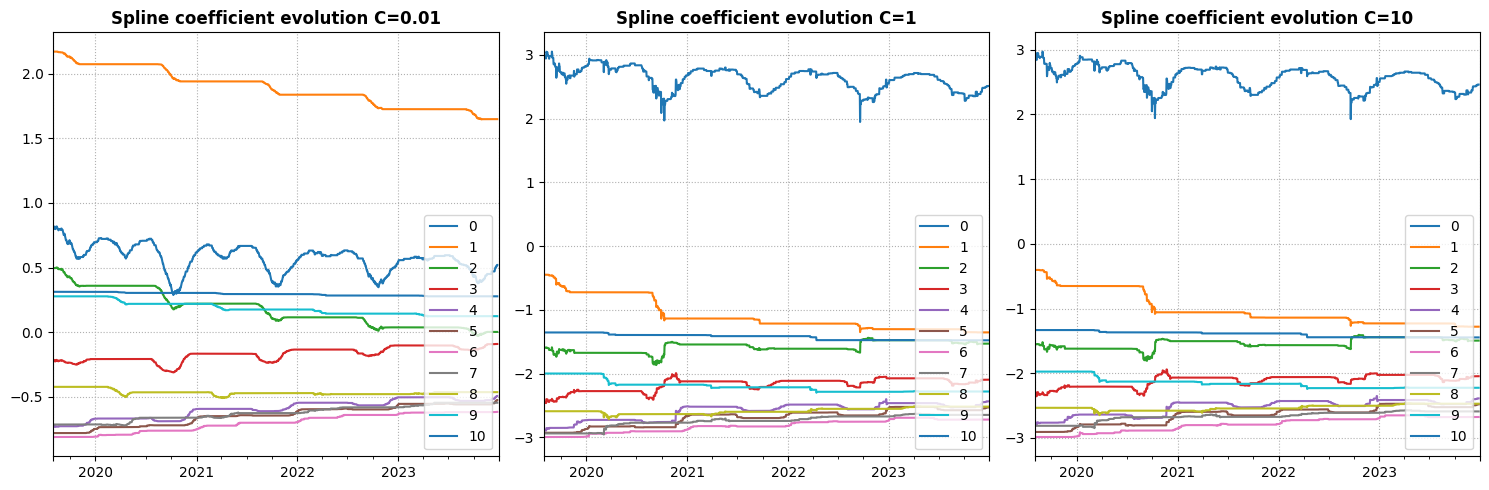

In [ ]:
# Coefficient evolution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pa_online_coeff[0.01].plot(ax=ax[0])
ax[0].grid(linestyle=':')
ax[0].set_title('Spline coefficient evolution C=0.01', fontweight='bold')
ax[0].legend(loc='lower right')

pa_online_coeff[1].plot(ax=ax[1])
ax[1].grid(linestyle=':')
ax[1].set_title('Spline coefficient evolution C=1', fontweight='bold')
ax[1].legend(loc='lower right')

pa_online_coeff[10].plot(ax=ax[2])
ax[2].grid(linestyle=':')
ax[2].set_title('Spline coefficient evolution C=10', fontweight='bold')
ax[2].legend(loc='lower right')

plt.tight_layout()

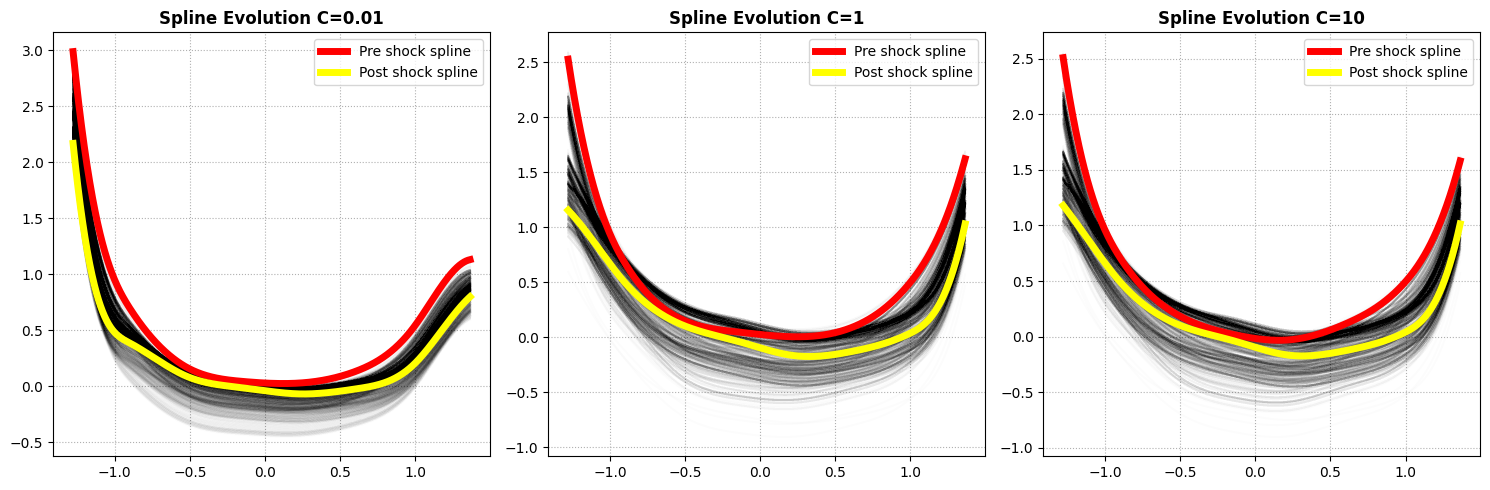

In [ ]:
# Spline evolution

def plot_spline_evolution(spline_history, C: float, ax=None):
    
    spline_pivot = pd.pivot_table(spline_history[C], index = 'feature', columns='valuedate', values='spline')

    if ax is not None:
        plt.sca(ax=ax)

    for i in spline_pivot.columns:
        plt.plot(spline_pivot.index, spline_pivot[i], color='black', alpha=0.01)

    plt.plot(spline_pivot.index, spline_pivot.iloc[:, 0], label='Pre shock spline', linewidth=5, color='red')
    plt.plot(spline_pivot.index, spline_pivot.iloc[:, -1], label='Post shock spline', linewidth=5, color='yellow')
    plt.legend()
    plt.grid(linestyle=':')
    plt.title(f'Spline Evolution C={C}', fontweight='bold')



fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_spline_evolution(spline_history=spline_history, C=0.01, ax=ax[0])
plot_spline_evolution(spline_history=spline_history, C=1, ax=ax[1])
plot_spline_evolution(spline_history=spline_history, C=10, ax=ax[2])
plt.tight_layout()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3b915ef-340b-4091-a3de-0f725584c443' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>